# SIR models with CovsirPhy

In [1]:
# imports 
import pandas as pd
import covsirphy as cs
import matplotlib.pyplot as plt
from pprint import pprint

C:\Users\lukas\anaconda3\envs\Intro_to_Data_Science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [2]:
# loading the data -> stored in kaggle/input
# data will be downloaded if existing files are older than 24h
data_loader = cs.DataLoader(directory="kaggle/input")

# The number of cases and population values in jhu format
jhu_data = data_loader.jhu()

#cases and deaths whole dataset
total_df = jhu_data.total()

### Prepare the data

The first case in Switzerland was confirmed on 2020-02-24.

In [3]:
# get the population size at the starting point
whole_df = jhu_data.cleaned()
whole_df = whole_df.loc[(whole_df["Country"] == "Switzerland")].copy()
whole_df['Date'] = pd.to_datetime(whole_df['Date'])

# define a time range
start_date = pd.to_datetime('2020-09-01')
end_date = pd.to_datetime('2020-12-01')
mask = (whole_df['Date'] >= start_date) & (whole_df['Date'] <= end_date)
df_timerange = whole_df.loc[mask]

# drop provinces
province_mask = df_timerange["Province"] == "-"
df_timerange = df_timerange.loc[province_mask]
df_timerange.index = pd.RangeIndex(len(df_timerange))

In [4]:
df_timerange

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
0,2020-09-01,CHE,Switzerland,-,42959,4887,1772,36300,8513227
1,2020-09-02,CHE,Switzerland,-,43376,5101,1775,36500,8513227
2,2020-09-03,CHE,Switzerland,-,43814,5538,1776,36500,8513227
3,2020-09-04,CHE,Switzerland,-,44241,5963,1778,36500,8513227
4,2020-09-05,CHE,Switzerland,-,44536,5656,1780,37100,8513227
...,...,...,...,...,...,...,...,...,...
87,2020-11-27,CHE,Switzerland,-,322966,96221,4645,222100,8513227
88,2020-11-28,CHE,Switzerland,-,325277,98443,4734,222100,8513227
89,2020-11-29,CHE,Switzerland,-,326968,100050,4818,222100,8513227
90,2020-11-30,CHE,Switzerland,-,332236,77123,4913,250200,8513227


### setting up a simple SIR model

In [5]:
# setting parameter for the model
params = {'theta': 0.005, 'kappa': 0.005, 'rho': 0.1, 'sigma': 0.05}
start_dict = {'Fatal or Recovered': 1772 + 36300, 'Infected': 4887, 'Susceptible': 8513227 - 4887 - 36300}
population = 8513227
days = (end_date - start_date).days
print(days)

91


In [6]:
model = cs.SIR
model.EXAMPLE["param_dict"] = params
model.EXAMPLE['y0_dict'] = start_dict
model.EXAMPLE['population'] = population
model.EXAMPLE['step_n'] = days

# Set tau value and start date of records
example_data = cs.ExampleData(tau=1440, start_date="01Sep2020")
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'kappa': 0.005, 'rho': 0.1, 'sigma': 0.05, 'theta': 0.005},
 'population': 8513227,
 'step_n': 91,
 'y0_dict': {'Fatal or Recovered': 38072,
             'Infected': 4887,
             'Susceptible': 8472040}}


In [7]:
model = cs.SIR
area = {"country": "Switzerland"}
# Add records with SIR model
example_data.add(model, **area)


# Records with model variables
df = example_data.cleaned()
df

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered,ISO3,Population
0,2020-09-01 00:00:00,Switzerland,-,42959,4887,0,38072,-,8513227.0
1,2020-09-02 00:00:00,Switzerland,-,43457,5135,0,38322,-,8513227.0
2,2020-09-03 00:00:00,Switzerland,-,43981,5395,0,38586,-,8513227.0
3,2020-09-04 00:00:00,Switzerland,-,44531,5669,0,38862,-,8513227.0
4,2020-09-05 00:00:00,Switzerland,-,45110,5957,0,39153,-,8513227.0
...,...,...,...,...,...,...,...,...,...
87,2020-11-27 00:00:00,Switzerland,-,685038,311461,0,373577,-,8513227.0
88,2020-11-28 00:00:00,Switzerland,-,714231,324751,0,389480,-,8513227.0
89,2020-11-29 00:00:00,Switzerland,-,744549,338490,0,406059,-,8513227.0
90,2020-11-30 00:00:00,Switzerland,-,776018,352682,0,423336,-,8513227.0


In [8]:
# prepare the result dataframe
res_df = df.drop(["Country", "Province", "Confirmed", "ISO3", "Population"], axis = 1)

# add results from the model
res_df["actual Infected"] = df_timerange["Infected"]

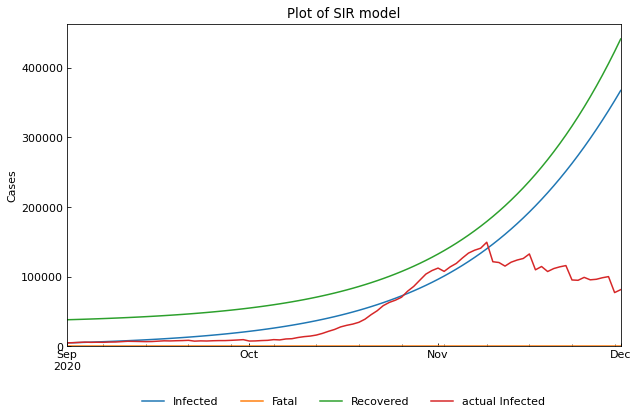

,Date,Infected,Fatal,Recovered,actual Infected
0,2020-09-01 00:00:00,4887,0,38072,4887
1,2020-09-02 00:00:00,5135,0,38322,5101
2,2020-09-03 00:00:00,5395,0,38586,5538
3,2020-09-04 00:00:00,5669,0,38862,5963
4,2020-09-05 00:00:00,5957,0,39153,5656
...,...,...,...,...,...
87,2020-11-27 00:00:00,311461,0,373577,96221
88,2020-11-28 00:00:00,324751,0,389480,98443
89,2020-11-29 00:00:00,338490,0,406059,100050
90,2020-11-30 00:00:00,352682,0,423336,77123


In [9]:
#cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)
cs.line_plot(res_df.set_index("Date"), title=f"Plot of {model.NAME} model", y_integer=True)
res_df